<a href="https://colab.research.google.com/github/mohitsharmas97/pytorch_notebooks/blob/main/Garbage_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mostafaabla/garbage-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'garbage-classification' dataset.
Path to dataset files: /kaggle/input/garbage-classification


In [ ]:
cd /kaggle/input/garbage-classification

/kaggle/input/garbage-classification


In [ ]:
ls

garbage_classification/


In [ ]:
import os

def walk_through(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walkthrough_path='/kaggle/input/garbage-classification'
walk_through(walkthrough_path)

There are 1 directories and 0 images in '/kaggle/input/garbage-classification'.
There are 12 directories and 0 images in '/kaggle/input/garbage-classification/garbage_classification'.
There are 0 directories and 769 images in '/kaggle/input/garbage-classification/garbage_classification/metal'.
There are 0 directories and 775 images in '/kaggle/input/garbage-classification/garbage_classification/white-glass'.
There are 0 directories and 985 images in '/kaggle/input/garbage-classification/garbage_classification/biological'.
There are 0 directories and 1050 images in '/kaggle/input/garbage-classification/garbage_classification/paper'.
There are 0 directories and 607 images in '/kaggle/input/garbage-classification/garbage_classification/brown-glass'.
There are 0 directories and 945 images in '/kaggle/input/garbage-classification/garbage_classification/battery'.
There are 0 directories and 697 images in '/kaggle/input/garbage-classification/garbage_classification/trash'.
There are 0 directo

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets ,models
from torchvision.transforms import transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using device :{device}")

using device :cuda


In [ ]:
torch.manual_seed(42)

In [ ]:
data_dir='/kaggle/input/garbage-classification/garbage_classification'
learning_rate=0.001
epochs=10
batch_size=32

In [ ]:
full_dataset=datasets.ImageFolder(data_dir)
class_names=full_dataset.classes
num_classes=len(class_names)
print(f"there are  {num_classes} classes in the dataset:{class_names}")

there are  12 classes in the dataset:['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [ ]:
train_samples,test_samples=train_test_split(full_dataset,
                                            test_size=0.2,
                                            random_state=42,
                                            stratify=[s[1] for s in full_dataset.samples]
                                            )

In [ ]:
custom_tranform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class Garbage_Classification(Dataset):
  def __init__(self,samples,transform=None):
    self.samples=samples
    self.transform=transform

  def __len__(self):
    return len(self.samples)

  def __getitem__(self,idx):
    image,label=self.samples[idx]
    image = image.convert('RGB')
    if self.transform is not None:
          image = self.transform(image)

    return image, torch.tensor(label, dtype=torch.long)


In [ ]:
train_dataset=Garbage_Classification(train_samples,custom_tranform)
test_dataset=Garbage_Classification(test_samples,custom_tranform)

In [ ]:
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [ ]:
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 73.5MB/s]


In [ ]:
for param in model.features.parameters():
  param.requires_grad=False

In [ ]:
model.classifier=nn.Sequential(
    # This line is correct. The input from efficientnet_b0 is 1280.
    nn.Linear(in_features=1280, out_features=1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=1024, out_features=512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=512, out_features=num_classes),
)

In [ ]:
model=model.to(device)

In [ ]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
for epoch in range(epochs):
  total_epoch_loss=0
  model.train()
  for batch_features,batch_labels in tqdm(train_loader):
    batch_features=batch_features.to(device)
    batch_labels=batch_labels.to(device)

    outputs=model(batch_features)
    loss = criterion(outputs, batch_labels) # Calculate the loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_epoch_loss+=loss.item()

  avg_epoch_loss=total_epoch_loss/len(train_loader)
  print(f"Epoch: {epoch+1}/{epochs}..")
  print(f"Train loss: {avg_epoch_loss}")

100%|██████████| 388/388 [00:54<00:00,  7.17it/s]


Epoch: 1/10..
Train loss: 0.553229595006434


100%|██████████| 388/388 [00:47<00:00,  8.14it/s]


Epoch: 2/10..
Train loss: 0.30578922183185664


100%|██████████| 388/388 [00:47<00:00,  8.09it/s]


Epoch: 3/10..
Train loss: 0.25374401013424486


100%|██████████| 388/388 [00:48<00:00,  8.06it/s]


Epoch: 4/10..
Train loss: 0.22559667835684166


100%|██████████| 388/388 [00:48<00:00,  7.99it/s]


Epoch: 5/10..
Train loss: 0.2014968031393268


100%|██████████| 388/388 [00:48<00:00,  8.08it/s]


Epoch: 6/10..
Train loss: 0.19648476581079596


100%|██████████| 388/388 [00:47<00:00,  8.21it/s]


Epoch: 7/10..
Train loss: 0.1706882775389138


100%|██████████| 388/388 [00:47<00:00,  8.16it/s]


Epoch: 8/10..
Train loss: 0.16099305285144472


100%|██████████| 388/388 [00:47<00:00,  8.13it/s]


Epoch: 9/10..
Train loss: 0.15944849853415868


100%|██████████| 388/388 [00:48<00:00,  7.99it/s]

Epoch: 10/10..
Train loss: 0.15032602639655226


In [ ]:
print("\nEvaluating on Test Set...")
total = 0
correct = 0
model.eval() # Set model to evaluation mode

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        # Move data to GPU
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        outputs = model(batch_features)
        predicted = torch.max(outputs, 1)

        total += batch_labels.shape[0]
        correct += (predicted.indices == batch_labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy*100:.2f}%')


Evaluating on Test Set...
Test Accuracy: 95.29%


In [ ]:
print("\nEvaluating on Test Set...")
total = 0
correct = 0
model.eval() # Set model to evaluation mode

with torch.no_grad():
    for batch_features, batch_labels in train_loader:
        # Move data to GPU
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        outputs = model(batch_features)
        predicted = torch.max(outputs, 1)

        total += batch_labels.shape[0]
        correct += (predicted.indices == batch_labels).sum().item()

accuracy = correct / total
print(f'Training Accuracy: {accuracy*100:.2f}%')


Evaluating on Test Set...
Training Accuracy: 99.14%


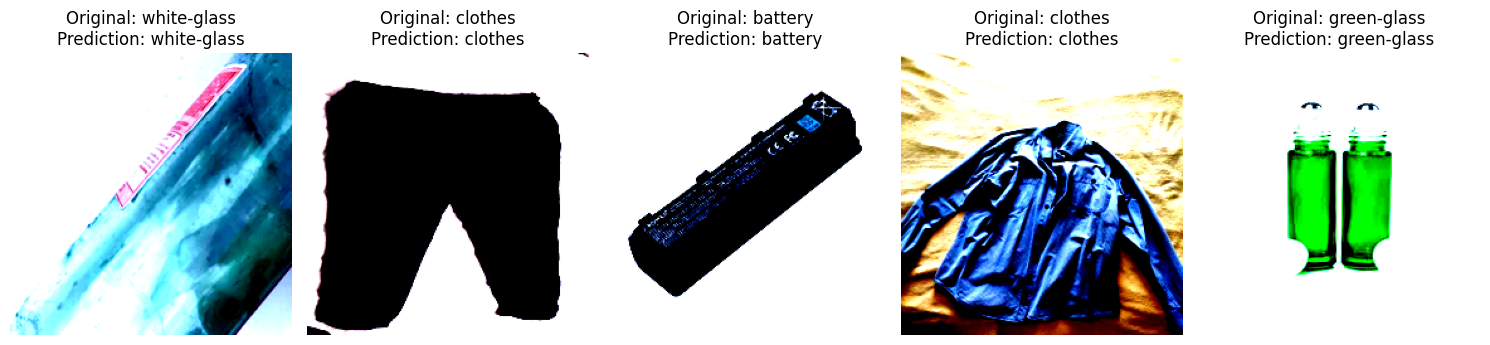

In [ ]:
import random
import matplotlib.pyplot as plt

# Get 5 random images from the test dataset
random_indices = random.sample(range(len(test_dataset)), 5)

plt.figure(figsize=(15, 10))

for i, idx in enumerate(random_indices):
    image, label = test_dataset[idx]
    original_label = class_names[label]

    # Add batch dimension and move to device
    image = image.unsqueeze(0).to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted_idx = torch.max(outputs, 1)
        predicted_label = class_names[predicted_idx.item()]

    # Display the image and prediction
    plt.subplot(1, 5, i + 1)
    plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy()) # Permute for matplotlib
    plt.title(f'Original: {original_label}\nPrediction: {predicted_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import os

# Define the path to save the model
model_save_path = '/content/garbage_classification_model.pth'

# Change to a writable directory
os.chdir('/content/')

# Save the model state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /content/garbage_classification_model.pth
